In [1]:
library(DESeq2)
library(enrichplot)
library(clusterProfiler)
library(ggplot2)
library(tidyr)
library(dplyr)
library(ggrepel)  # For non-overlapping text labels
library(org.Hs.eg.db)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [5]:
deseq_brain = readRDS('../../rds/deseq2_brain_mockvirus.rds')
deseq_gundiff = readRDS('../../rds/deseq2_gut_undiff_mockvirus.rds')
deseq_gdiff = readRDS('../../rds/deseq2_gut_diff_mockvirus.rds')
genes = read.csv('../../output/gut/gut_genes.csv',row.names = 1)


	Pearson's product-moment correlation

data:  x and y
t = 27.798, df = 11809, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2308249 0.2646800
sample estimates:
      cor 
0.2478281 


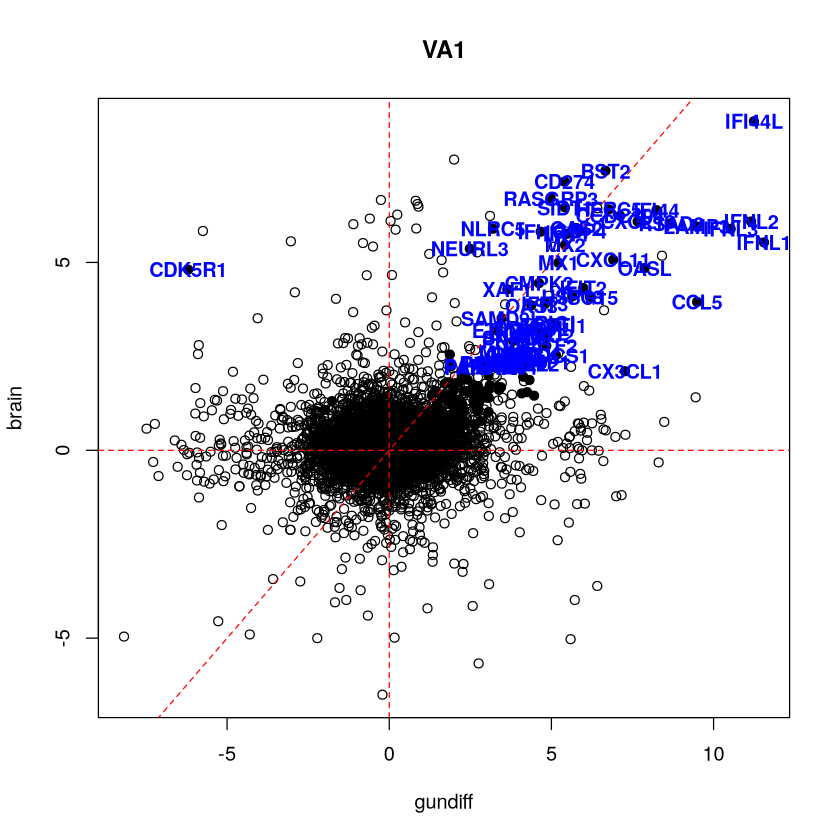

In [10]:
v = 'VA1'
xcnd = deseq_gdiff
ycnd = deseq_gundiff 

cmn = intersect(rownames(xcnd[[v]]),rownames(ycnd[[v]]))
sgn = xcnd[[v]][cmn,'padj'] < 0.05 & ycnd[[v]][cmn,'padj'] < 0.05
sgn[is.na(sgn)] = FALSE
x = xcnd[[v]][cmn,'log2FoldChange']
y = ycnd[[v]][cmn,'log2FoldChange']

plot(x,y,pch=ifelse(sgn,19,1),xlab='gundiff',ylab='brain',main=v)
abline(h=0,col='red',lty=2)
abline(v=0,col='red',lty=2)
abline(a=0,b=1,col='red',lty=2)

selgenes = sgn & abs(xcnd[[v]][cmn,'log2FoldChange']) > 2 &  abs(ycnd[[v]][cmn,'log2FoldChange']) > 2 
text(x[selgenes],y[selgenes],genes[cmn[selgenes],'gene_name'],col='blue',font=2)
cor.test(x,y,m='p')

In [28]:
length(x)


[1] 11811

In [29]:
plotPair = function(xcnd,ycnd,xlab,ylab,title,sgnby='x',gene_names=genes){
    # Build a data frame
    cmn <- intersect(rownames(xcnd), rownames(ycnd))
    
    plot_df <- data.frame(
      gene_id = cmn,
      x = xcnd[cmn, "log2FoldChange"],
      y = ycnd[cmn, "log2FoldChange"],
      xpadj = xcnd[cmn, "padj"],
      ypadj = ycnd[cmn, "padj"]
    )
    
    # Add gene names
    plot_df$gene_name <- gene_names[plot_df$gene_id, "gene_name"]
    
    # Define significance and label criteria
    
    plot_df$significant = rowSums(plot_df[,paste0(strsplit(sgnby,'')[[1]],'padj'),drop=FALSE] < 0.05) == nchar(sgnby)
    plot_df$significant[is.na(plot_df$significant)] = FALSE
    plot_df$label <- ifelse(
      plot_df$significant &
        abs(plot_df$x) > 2 &
        abs(plot_df$y) > 2,
      plot_df$gene_name,''
    )
    
    # Plot
    p <- ggplot(plot_df, aes(x = x, y = y)) +
      geom_point(aes(shape = significant), size = 2) +
      geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
      geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
      geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
      geom_text_repel(aes(label = label), size = 3.5, color = "blue", max.overlaps = Inf) +
      theme_minimal() +
      labs(
        title = title,
        x = xlab,
        y = ylab
      ) +
      theme(legend.position = "none")
}

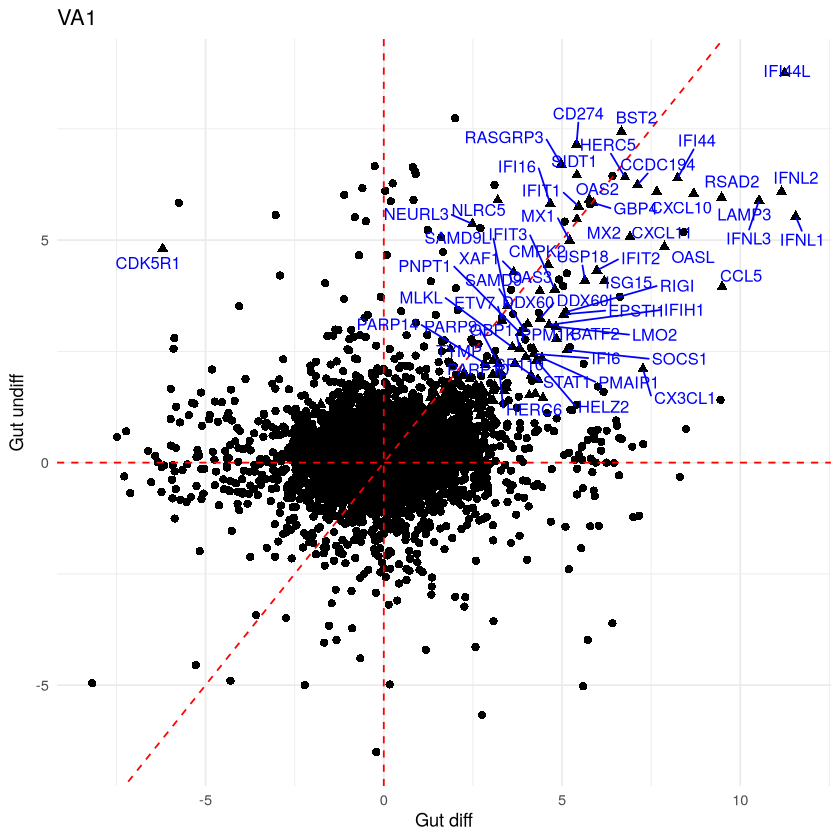

In [30]:
#vir <- "VA1"

#p = plotPair(xcnd = deseq_gdiff[[vir]],
#             ycnd = deseq_gundiff[[vir]],
#             xlab = "Gut diff", ylab = "Gut undiff",
#             title = vir,
#            sgnby='xy')
# Show plot
#print(p)

# Save wide plot if needed
#ggsave("ggplot_VA1_gdiff_vs_gundiff.png", p, width = 10, height = 8, dpi = 300)


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


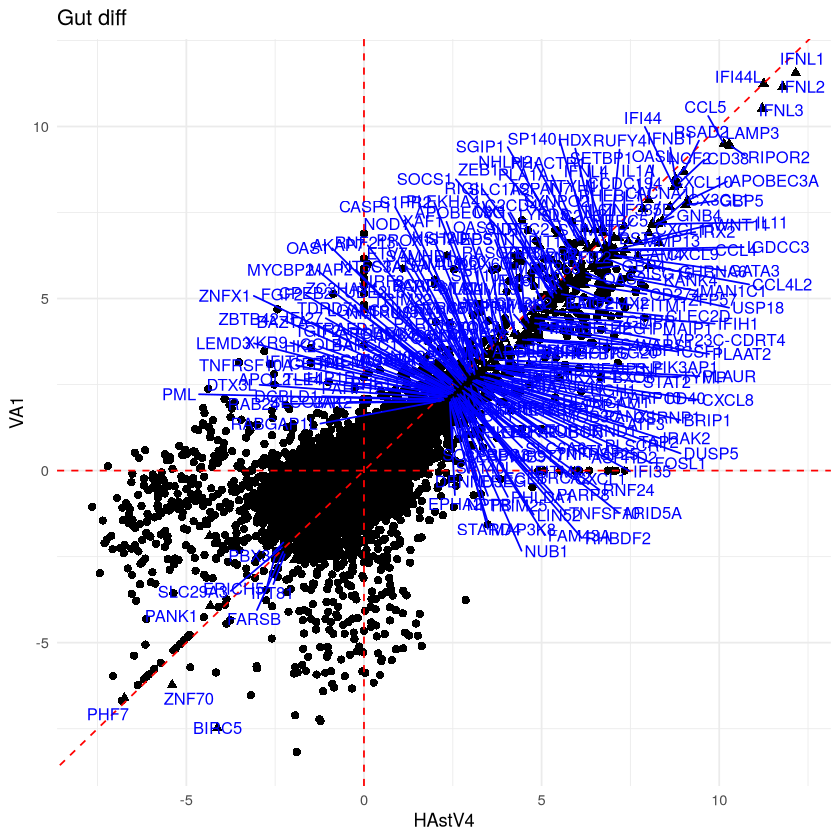

In [32]:
p = plotPair(xcnd = deseq_gdiff$HAstV4,
             ycnd = deseq_gdiff$VA1,
             xlab = "HAstV4", ylab = "VA1",
             title = "Gut diff",
            sgnby='xy')
p

In [33]:
# Save wide plot if needed
ggsave("ggplot_Gundiff_HAstV4_vs_VA1.png", p, width = 10, height = 8, dpi = 300)


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


In [ ]:
p = plotPair(xcnd = deseq_gdiff$HAstV4,
             ycnd = deseq_gdiff$VA1,
             xlab = "HAstV4", ylab = "VA1",
             title = "Gut diff",
            sgnby='xy')
p

In [34]:
print(plotPair)

function (xcnd, ycnd, xlab, ylab, title, sgnby = "x", gene_names = genes) 
{
    cmn <- intersect(rownames(xcnd), rownames(ycnd))
    plot_df <- data.frame(gene_id = cmn, x = xcnd[cmn, "log2FoldChange"], 
        y = ycnd[cmn, "log2FoldChange"], xpadj = xcnd[cmn, "padj"], 
        ypadj = ycnd[cmn, "padj"])
    plot_df$gene_name <- gene_names[plot_df$gene_id, "gene_name"]
    plot_df$significant = rowSums(plot_df[, paste0(strsplit(sgnby, 
        "")[[1]], "padj"), drop = FALSE] < 0.05) == nchar(sgnby)
    plot_df$significant[is.na(plot_df$significant)] = FALSE
    plot_df$label <- ifelse(plot_df$significant & abs(plot_df$x) > 
        2 & abs(plot_df$y) > 2, plot_df$gene_name, "")
    p <- ggplot(plot_df, aes(x = x, y = y)) + geom_point(aes(shape = significant), 
        size = 2) + geom_hline(yintercept = 0, linetype = "dashed", 
        color = "red") + geom_vline(xintercept = 0, linetype = "dashed", 
        color = "red") + geom_abline(slope = 1, intercept = 0, 
        color = "r

In [40]:
plotPair <- function(xcnd, ycnd, xlab, ylab, title, sgnby = "x", gene_names = genes, top_n = 50) {
  cmn <- intersect(rownames(xcnd), rownames(ycnd))
  plot_df <- data.frame(
    gene_id = cmn,
    x = xcnd[cmn, "log2FoldChange"],
    y = ycnd[cmn, "log2FoldChange"],
    xpadj = xcnd[cmn, "padj"],
    ypadj = ycnd[cmn, "padj"]
  )
  
  plot_df$gene_name <- gene_names[plot_df$gene_id, "gene_name"]
  
  # Significance by selected direction (x/y/xy)
  plot_df$significant <- rowSums(
    plot_df[, paste0(strsplit(sgnby, "")[[1]], "padj"), drop = FALSE] < 0.05
  ) == nchar(sgnby)
  plot_df$significant[is.na(plot_df$significant)] <- FALSE

  # Filter strongly regulated & significant genes for labeling
  label_df <- plot_df %>%
    filter(significant & abs(x) > 2 & abs(y) > 2) %>%
    arrange((xpadj + ypadj)/2) %>%   # Average padj to rank by significance
    head(top_n)

  # Set labels
  plot_df$label <- ifelse(plot_df$gene_id %in% label_df$gene_id, plot_df$gene_name, "")

  # Create plot
  p <- ggplot(plot_df, aes(x = x, y = y)) +
    geom_point(aes(shape = significant), size = 2) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "red") +
    geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
    geom_text_repel(aes(label = label), size = 3.5, color = "blue", max.overlaps = Inf) +
    theme_minimal() +
    labs(title = title, x = xlab, y = ylab) +
    theme(legend.position = "none")

  return(p)
}


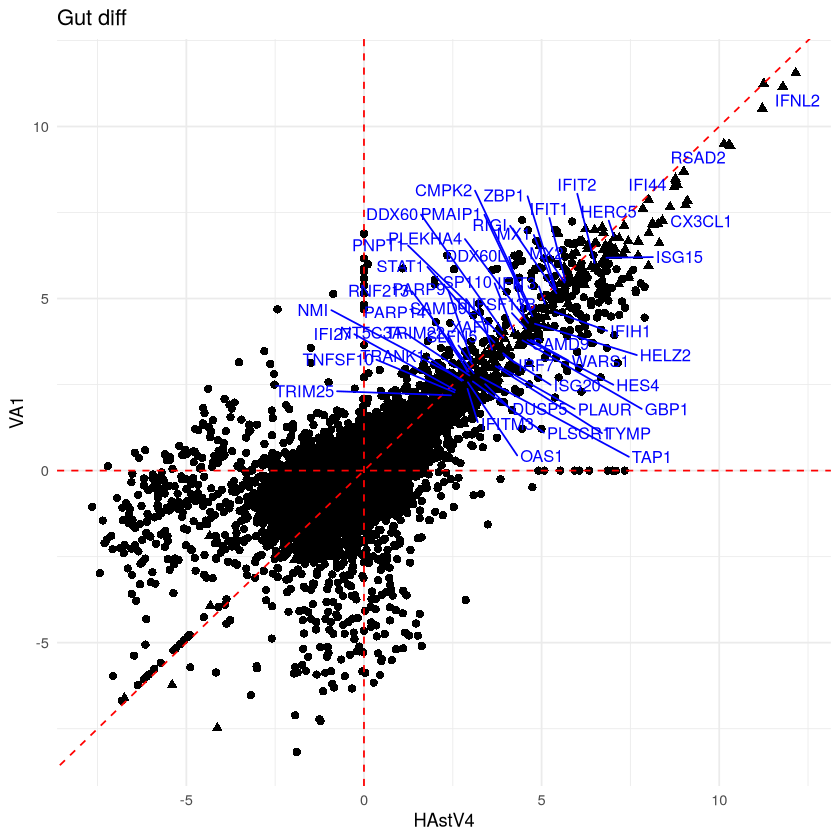

In [41]:
p = plotPair(xcnd = deseq_gdiff$HAstV4,
             ycnd = deseq_gdiff$VA1,
             xlab = "HAstV4",
             ylab = "VA1",
             title = "Gut diff",
             sgnby = 'xy',
             top_n = 50)
p
